## Variational Autoencoder
VAE with Gaussian encoder and Bernoulli decoder networks.

## Imports

In [4]:
import math

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision.datasets as datasets

from matplotlib import pyplot as plt

from tqdm import tqdm

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=None)

### Computing device
CPU or GPU (cuda)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Dataloaders

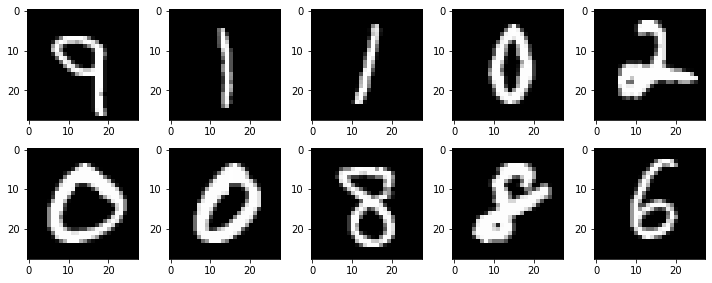

Number training batches: 938
Batch x Width x Height: [64, 28, 28]


In [134]:
%matplotlib inline

train_data = mnist_train.data.to(device)
test_data = mnist_test.data.to(device)

train_data = train_data / train_data.max()
test_data = test_data / test_data.max()

train_loader = DataLoader(list(train_data), batch_size=64, shuffle=True)
test_loader = DataLoader(list(test_data), batch_size=64, shuffle=False)

first_batch = next(iter(train_loader))
sample_images = first_batch[:10].cpu().numpy()

fig, axes = plt.subplots(2, 5, figsize=(2*5, 2*2))
for i in range(10):
    ax = axes[divmod(i,5)]
    ax.imshow(sample_images[i], cmap='gray')
plt.tight_layout()
plt.show()

num_batches = len(train_loader)
print(f'Number training batches: {len(train_loader)}')
print(f'Batch x Width x Height: {list(first_batch.shape)}')

### Model Definition
hard coded for 28x28 images (MNIST).

In [171]:
class VAE_Conv(nn.Module):

    def __init__(self, latent_size) -> None:
        super().__init__()

        # conv encoder
        block_0_ch = 16
        self.encoder_block_0 = nn.Sequential(
            nn.Conv2d(1, block_0_ch, 5), # 24
            nn.MaxPool2d(2, 2), # 12
            nn.BatchNorm2d(block_0_ch)
        )
        self.encoder = nn.ModuleList()
        in_ch = block_0_ch
        h_ch = 2*in_ch
        out_ch = 2*h_ch
        self.encoder.append(
            nn.ModuleList([
                nn.Conv2d(in_ch, out_ch, 1, 2), # 6
                nn.Sequential(
                    nn.Conv2d(in_ch, h_ch, 3, 2, 1), # 6
                    nn.BatchNorm2d(h_ch),
                    nn.ReLU(),
                    nn.Conv2d(h_ch, out_ch, 3, 1, 1), # 6
                    nn.BatchNorm2d(out_ch),
                )
            ])
        )
        self.skip_e = nn.Conv2d(1, out_ch, 23) # 6
        self.encoder_out = nn.Sequential(
            nn.ReLU(),
            nn.AvgPool2d(6,6),
            nn.Flatten(start_dim=1, end_dim=-1),
            nn.Linear(out_ch, 2*latent_size),
        )

        # upconv decoder
        in_ch = 2*out_ch
        self.decoder_in = nn.Linear(latent_size, in_ch)
        self.decoder = nn.ModuleList()
        
        for i in range(5):
            h_ch = in_ch//2
            out_ch = in_ch//2
            self.decoder.append(
                nn.ModuleList([
                    nn.ConvTranspose2d(in_ch, out_ch, 2, 2), # 8
                    nn.Sequential(
                        nn.ConvTranspose2d(in_ch, h_ch, (2,1), (2,1)), # 4
                        nn.BatchNorm2d(h_ch),
                        nn.ReLU(),
                        nn.ConvTranspose2d(h_ch, out_ch, (1,2), (1,2)), # 8
                        nn.BatchNorm2d(out_ch),
                    )
                ])
            )
            in_ch = out_ch

        self.decoder.append(
            nn.ModuleList([
                nn.Conv2d(out_ch, 8, 5), # 28
                nn.Sequential(
                    nn.Conv2d(out_ch, 8, 3), # 30
                    nn.BatchNorm2d(8),
                    nn.ReLU(),
                    nn.Conv2d(8, 8, 3), # 28
                    nn.BatchNorm2d(8),
                )
            ])
        )
        self.decoder.append(
            nn.ModuleList([
                nn.Conv2d(8, 8, 1), # 28
                nn.Sequential(
                    nn.Conv2d(8, 8, 3, 1, 1), # 28
                    nn.BatchNorm2d(8),
                    nn.ReLU(),
                    nn.Conv2d(8, 8, 3, 1, 1), # 28
                    nn.BatchNorm2d(8),
                )
            ])
        )
        
        self.decoder_out = nn.Sequential(
            nn.Conv2d(8, 4, 3, 1, 1),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.Conv2d(4, 1, 1)
        )
    
    
    def forward(self, x):
        x = F.dropout(x, 0.2)
        B = x.size(0)
        x = x.unsqueeze(1)
        skip_x = self.skip_e(x)
        x = self.encoder_block_0(x)
        for res, block in self.encoder:
            x = F.relu(res(x) + block(x))
        
        mu_z, logvar_z = self.encoder_out(skip_x + x).chunk(2, dim=-1)

        std_z = torch.exp(0.5 * logvar_z)
        eps = torch.randn_like(std_z)

        z = std_z * eps + mu_z
        
        h = self.decoder_in(z)
        
        h = h.view(B, -1, 1, 1)
        for res, block in self.decoder:
            h = F.relu(res(h) + block(h))

        logits = self.decoder_out(h).view(-1, 28, 28) 
        kld = torch.mean(-0.5 * torch.sum(1 + logvar_z - (mu_z ** 2) - logvar_z.exp(), dim=1))

        return torch.sigmoid(logits), kld



### KL-Weight Scheduler

[4.53978687e-05 4.54099695e-05 4.54220736e-05 ... 9.99999694e-01
 9.99999694e-01 9.99999694e-01]


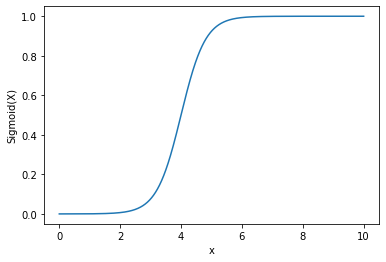

In [183]:
import matplotlib.pyplot as plt
import numpy as np

epochs = 100
x = np.linspace(0, 10, num_batches * epochs)
z = 1/(1 + np.exp(-2.5*(x-4))) # shifted sigmoid
  
plt.plot(x, z)
plt.xlabel("x")
plt.ylabel("f(x)")
  
plt.show()

## Training

In [173]:
model = VAE_Conv(latent_size=4).to(device)
optimizer = torch.optim.Adam(model.parameters(), 0.0005)

model.train()

epochs = 200
x_ticks = torch.linspace(0, 10, num_batches * epochs)
kl_weights = 1/(1 + torch.exp(-2.5*(x_ticks-4))).detach()

loss_history = []
kld_history = []
kld_weight = 0
step = 0
for i in tqdm(range(epochs)):
    avg_log_prob = 0
    avg_kld = 0
    for i, x in enumerate(train_loader):
        optimizer.zero_grad()

        rec, kld = model(x)
        # bernoulli log prob equals binary cross entropy
        # log_prob = F.binary_cross_entropy(rec, x)
        log_prob = -torch.mean(torch.sum((x * torch.log(rec)) + (1 - x) * torch.log(1 - rec), dim=(1,2)), dim=0)

        kld_weight = kl_weights[step]
        loss = kld_weight * kld + log_prob
        
        avg_log_prob += log_prob.item()
        avg_kld += kld.item()
                
        loss.backward()
        optimizer.step()
        step += 1
    avg_log_prob /= i+1
    avg_kld /= i+1

    # print(step, avg_log_prob, avg_kld)

    kld_history.append(avg_kld)
    loss_history.append(avg_log_prob)

print("Train log likelihood: {:.4f}".format(avg_log_prob))

torch.save(model.state_dict(), 'model_bernoulli.pt')

100%|██████████| 200/200 [1:25:41<00:00, 25.71s/it]

Train log likelihood: 108.8629


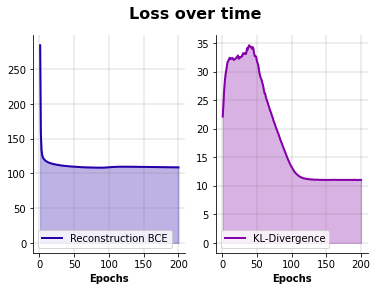

In [174]:
### RESULTS PLOT
colors = ['#2300a8', '#8400a8'] # '#8400a8', '#00A658'
plot_dict = {'Reconstruction BCE': (loss_history, colors[0]), 'KL-Divergence': (kld_history, colors[1])}
# plot_dict = {'Reconstruction': (loss_history, colors[0])}

n = len(loss_history)

# plot train and val losses and log_likelihood area under the curve
fig, axes = plt.subplots(1,2)
x_axis = list(range(1, n+1))
for i, (key, (data, color)) in enumerate(plot_dict.items()):
    ax = axes[i]
    ax.plot(x_axis, data, 
                label=key, 
                linewidth=2, 
                linestyle='-', 
                alpha=1, 
                color=color)
    ax.fill_between(x_axis, data, 
                alpha=0.3, 
                color=color)
    
    ax.set_xlabel('Epochs', fontweight='bold')
    ax.legend(loc='lower left')

    # remove top and right borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # adds major gridlines
    ax.grid(color='grey', linestyle='-', linewidth=0.35, alpha=0.8)

fig.suptitle('Loss over time', fontweight='bold', fontsize=16)

# y-axis in log scale (reconstruction loss tends to start high)
# ax.set_yscale('log')
plt.show()

## Testing

In [175]:
model.load_state_dict(torch.load('model2.pt'))

### TEST 
model.eval()
log_prob = 0
reconstructions = []
with torch.no_grad():
    h, c = None, None
    for i, x in enumerate(test_loader):
        rec, kld = model(x)
        
        log_prob -= torch.mean(torch.sum((x * torch.log(rec)) + (1 - x) * torch.log(1 - rec), axis=(1,2)), axis=0)
        reconstructions.append((x, rec))

    log_prob /= i+1


print("Test log likelihood: {:.4f}".format(log_prob))

Test log likelihood: 110.9773


### Plots
sample inputs and reconstructions

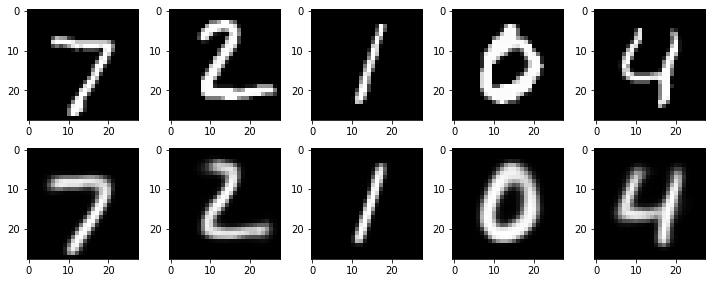

In [181]:
input, reconstructed = reconstructions[0][:5]

fig, axes = plt.subplots(2, 5, figsize=(2*5, 2*2))
for i in range(5):
    ax = axes[0,i]
    ax.imshow(input[i].cpu().numpy(), cmap='gray')
    ax = axes[1,i]
    ax.imshow(reconstructed[i].cpu().numpy(), cmap='gray')
plt.tight_layout()
plt.show()